In [134]:
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy import stats

%matplotlib inline

In [135]:
listings_df = pd.read_csv('./listings.csv')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [136]:
# Remove the columns that are just URLs, they won't help analysis or predictions

url_cols = [x for x in listings_df.columns if 'url' in x]
listings_df.drop(url_cols, axis=1, inplace=True)

# Remove columns that are all of 1 value
for col in listings_df.columns:
    if len(listings_df[col].unique()) == 1:
        listings_df.drop(col, axis=1, inplace=True)

# Columns that have $ in every rows are monetary columns, turn these into floats
for col in listings_df.select_dtypes('object').columns:
    if listings_df[col].str.contains("\$").mean() == 1:
        listings_df[col] = listings_df[col].replace('[\$,]', '', regex=True).astype(float)

In [137]:
cat_cols = listings_df.select_dtypes('object').columns
num_cols = listings_df.select_dtypes(['float', 'int']).columns

## Clean and standardize text columns

In [138]:
def standardize_text(df, text_field):
    """
    INPUT: DataFrame and text_field column
    OUTPUT: DataFrame with text_field column standardized (e.g. caps turned to lower case, urls removed etc.)
    """
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

def remove_missing_amenities_from_list(amenities_list):
    """
    INPUT: List of amenities strings
    OUTPUT: List of amenities strings with unwanted strings (that have 'missing' in them) removed and excess spaces removed
    """
    return [" ".join(x.split()) for x in amenities_list if "missing" not in x]

def clean_and_tokenize_amenities_column(df):
    """
    INPUT: Listings DataFrame
    OUTPUT: Listings DataFrame with amenities column cleaned and its elements tokenized
    """
    df['amenities'] = df['amenities'].apply(lambda col: re.sub("[{}\"]", "", col).lower().split(","))
    df['amenities'] = df['amenities'].apply(remove_missing_amenities_from_list)
    return df

In [139]:
# Standardize rest of the text-heavy columns

for col in cat_cols:
    listings_df = standardize_text(listings_df, col)

# Deal with Missing/Misleading Data

In [140]:
# Check how much data is missing in each column

for col in listings_df.columns:
    if listings_df[col].isna().mean() > 0:
        print("%s has %.2f%% values missing" %(col, listings_df[col].isna().mean() * 100))

summary has 3.99% values missing
space has 29.48% values missing
neighborhood_overview has 39.47% values missing
notes has 55.09% values missing
transit has 35.98% values missing
access has 41.53% values missing
interaction has 43.35% values missing
house_rules has 33.25% values missing
host_location has 0.31% values missing
host_about has 36.51% values missing
host_response_time has 13.14% values missing
host_response_rate has 13.14% values missing
host_acceptance_rate has 13.14% values missing
host_neighbourhood has 9.46% values missing
neighbourhood has 15.15% values missing
city has 0.06% values missing
zipcode has 1.06% values missing
market has 0.39% values missing
property_type has 0.08% values missing
bathrooms has 0.39% values missing
bedrooms has 0.28% values missing
beds has 0.25% values missing
square_feet has 98.44% values missing
weekly_price has 75.12% values missing
monthly_price has 75.23% values missing
security_deposit has 62.57% values missing
cleaning_fee has 30.88

### Amenities

In [141]:
# todo remove the null amenities columns

null_amenities_rows = listings_df[listings_df['amenities'].apply(lambda x: len(x)==2)].index

In [122]:
listings_df[listings_df['amenities'].apply(lambda x: len(x)==54)]

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
636,8011545,"private br in north end, boston",great bedroom in shared appartment located in ...,NaN,great bedroom in shared appartment located in ...,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,10.0,f,flexible,f,f,1,3.96


### Text heavy columns with lots of NAs

In [123]:
# Drop complex text-heavy columns with a lot of missing values (~30-50% missing)
listings_df.drop(
    [
        'space', 
        'neighborhood_overview', 
        'notes', 
        'transit', 
        'access', 
        'interaction', 
        'house_rules',
        'host_about',
    ], axis=1, inplace=True
)

### City

In [124]:
# Look at city, see if it adds any value

for city, group in listings_df.groupby('city'):
    print("%s has %.2f%% of the total rows" %(city, group.shape[0] / listings_df.shape[0] * 100))

# Around 95% of the values are some variant of Boston, the rest are actually neighborhoods, 
# as we can see from the neighborhood column. So drop this column.
listings_df.drop('city', axis=1, inplace=True)

    has 0.03% of the total rows
allston has 0.39% of the total rows
boston has 94.34% of the total rows
boston  has 0.03% of the total rows
boston (charlestown) has 0.03% of the total rows
boston (jamaica plain) has 0.03% of the total rows
boston, massachusetts, us has 0.06% of the total rows
brighton has 0.42% of the total rows
brighton  has 0.03% of the total rows
brookline has 0.50% of the total rows
cambridge has 0.45% of the total rows
charlestown has 0.42% of the total rows
dorchester has 0.42% of the total rows
dorchester, boston  has 0.03% of the total rows
east boston has 0.08% of the total rows
east boston  has 0.03% of the total rows
hyde park has 0.06% of the total rows
jamaica plain has 0.50% of the total rows
jamaica plain  has 0.08% of the total rows
jamaica plain (boston) has 0.03% of the total rows
jamaica plain, boston has 0.06% of the total rows
jamaica plain, ma has 0.03% of the total rows
mattapan has 0.08% of the total rows
milton has 0.03% of the total rows
missi

In [125]:
def groupby_mode_fillna(df, col_to_fill, col_to_groupby):
    """
    Function that imputes the mean for a column using a groupby on another column to find the mode
    INPUT: DataFrame, column with na's to fill, column to groupby for finding modes
    """
    modes = df.groupby(col_to_groupby)[col_to_fill].apply(lambda x: x.mode())
    df[col_to_fill] = df[col_to_fill].fillna(df[col_to_groupby].apply(lambda x: modes[modes.index==(x, 0)]))
    
    return df

### Neighbourhood and Zipcode

In [131]:
print(listings_df['neighbourhood'].isna().mean())
print(listings_df['neighbourhood_cleansed'].isna().mean())

# Neighbourhood and neighbourhood_cleansed are very similar columns, but cleansed has no nas
# Drop neighbourhood to avoid instability

listings_df.drop('neighbourhood', axis=1, inplace=True)

0.1514644351464435
0.0


In [133]:
for neighbourhood, group in listings_df.groupby('neighbourhood_cleansed'):
    print("%s has %.2f%% of its zipcode values missing with %s members" %(neighbourhood, group['zipcode'].isna().mean() * 100, len(group)))
    print(group['zipcode'].value_counts(dropna=False))
    
# A lot of neighbourhoods have one much more common zipcode, so we'll fillna with these

listings_df = groupby_mode_fillna(listings_df, 'zipcode', 'neighbourhood_cleansed')

allston has 0.00% of its zipcode values missing with 260 members
02134         224
02215          10
02139           6
02138           6
02135           5
02446           4
02163           3
02114           1
02134 1704      1
Name: zipcode, dtype: int64
back bay has 0.00% of its zipcode values missing with 302 members
02116    203
02115     84
02215      8
02134      3
02118      2
02142      1
02114      1
Name: zipcode, dtype: int64
bay village has 0.00% of its zipcode values missing with 24 members
02116    24
Name: zipcode, dtype: int64
beacon hill has 0.00% of its zipcode values missing with 194 members
02114    144
02108     43
02116      3
02111      1
02113      1
02118      1
02126      1
Name: zipcode, dtype: int64
brighton has 0.00% of its zipcode values missing with 185 members
02135    167
02134     12
02445      3
02446      1
02111      1
02115      1
Name: zipcode, dtype: int64
charlestown has 0.00% of its zipcode values missing with 111 members
02129    90
02145    12

In [15]:
for neighbourhood, group in listings_df.groupby('neighbourhood'):
    print("%s has %.2f%% of its neighborhood values missing with %s members" %(zipcode, group['neighbourhood'].isna().mean() * 100, len(group)))
    print(group['zipcode'].value_counts(dropna=False))
    
# A lot of neighbourhoods have one much more common zipcode, so we'll fillna with these

listings_df = groupby_mode_fillna(listings_df, 'zipcode', 'neighbourhood')

02472 has 0.00% of its neighborhood values missing with 364 members
02134         195
02135         154
02215           9
02163           2
02134 1704      1
02445           1
02114           1
02115           1
Name: zipcode, dtype: int64
02472 has 0.00% of its neighborhood values missing with 291 members
02116    206
02115     77
02215      7
02114      1
Name: zipcode, dtype: int64
02472 has 0.00% of its neighborhood values missing with 717 members
02114    157
02134     71
02108     55
02116     41
02124     34
02118     29
02128     28
02115     28
02130     27
02215     27
02127     23
02135     18
02120     18
02125     17
02119     16
02113     16
02210     16
02111     14
02129     12
02126      9
02136      7
02121      7
02122      7
02109      6
02131      6
02132      6
02143      4
02138      3
02446      3
02145      2
02218      1
02110      1
02186      1
02169      1
02139      1
02142      1
02141      1
02467      1
02472      1
02163      1
Name: zipcode, dtype: in

### Beds, Bedrooms and Bathrooms

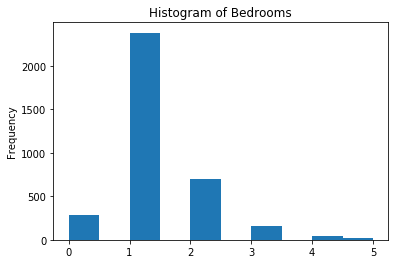

0.3% NaN Bedrooms


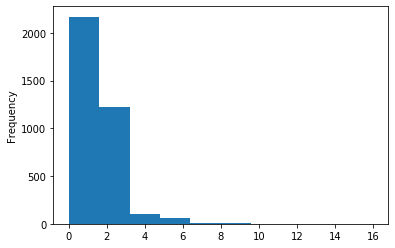

0.3% NaN Beds


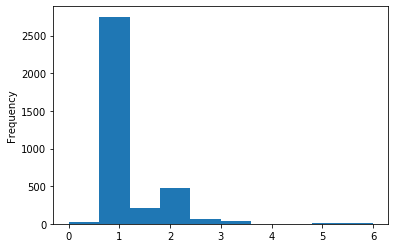

0.4% NaN Bathrooms


In [16]:
listings_df['bedrooms'].plot.hist()
plt.title('Histogram of Bedrooms')
plt.show()
print("%.1f%% NaN Bedrooms" %(listings_df['bedrooms'].isna().mean()*100))

listings_df['beds'].plot.hist();
plt.show()
print("%.1f%% NaN Beds" %(listings_df['beds'].isna().mean()*100))

listings_df['bathrooms'].plot.hist()
plt.show()
print("%.1f%% NaN Bathrooms" %(listings_df['bathrooms'].isna().mean()*100))

# Simple mode fill seems like it works here, very few missing values anyway

for c in ['bedrooms', 'bathrooms', 'beds']:
    listings_df[c] = listings_df[c].fillna(listings_df[c].mode()[0])

#### True/False Columns

In [17]:
for c in [
    'host_is_superhost', 
    'host_has_profile_pic', 
    'host_identity_verified', 
    'is_location_exact',
    'instant_bookable',
    'require_guest_phone_verification',
    'require_guest_profile_picture'
]:
    listings_df[c] = listings_df[c].apply(lambda x: True if (x=='t' or x==True) else False)

## Remove Cols that are too messy/are redundant/worthless

In [18]:
irrelevant_cols = [
    'name', 
    'summary', 
    'description', 
    'host_name', 
    'host_since', 
    'host_location', 
    'host_neighbourhood', 
    'host_verifications',
    'street',
    'market',
    'smart_location',
    'calendar_updated',
    'first_review',
    'last_review',
    'reviews_per_month'
]

listings_df.drop(irrelevant_cols, axis=1, inplace=True)

## Remove potential leakage columns

In [19]:
leakage_cols = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'weekly_price', 'monthly_price',
    'cleaning_fee'
]

listings_df.drop(leakage_cols, axis=1, inplace=True)

## Turn "rate" columns into numeric rather than categorical

In [20]:
for c in ['host_response_rate', 'host_acceptance_rate']:
    listings_df[c] = listings_df[c].astype(float)

## Square Feet

In [21]:
# Square feet is missing 98.4% of its data, not going to be useful unfortunately

listings_df.drop('square_feet', axis=1, inplace=True)

## Host Response Time and Rate

In [22]:
# Response rate and time seem to be missing the same values

print(listings_df.dropna(subset=['host_response_time'])['host_response_rate'].isna().mean())

# Just drop NAs for these

listings_df.dropna(subset=['host_response_time', 'host_response_rate'], inplace=True)

0.0


## Property Type

In [23]:
print(listings_df['property_type'].isna().sum())
# 2 values missing, just drop

listings_df.dropna(subset=['property_type'], inplace=True)

2


## Security Deposit

count    1233.000000
mean      321.978913
std       329.728373
min        95.000000
25%       100.000000
50%       250.000000
75%       446.000000
max      4500.000000
Name: security_deposit, dtype: float64


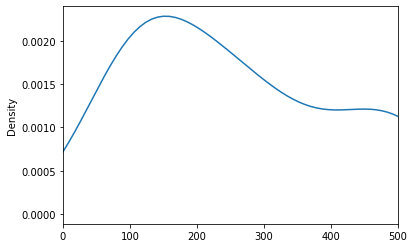

In [24]:
listings_df['security_deposit'].plot.kde(xlim=(0, 500))
print(listings_df['security_deposit'].describe())

# No deposits are below $95; seems unlikely there would be $0 values, use the median to fillna.
listings_df['security_deposit'].fillna(listings_df['security_deposit'].median(), inplace=True)

In [25]:
for col in listings_df.columns:
    if listings_df[col].isna().mean() > 0:
        print(col, listings_df[col].isna().mean()*100)

# Set up Dummy Columns

In [26]:
# Change amenities column string into a clean tokenized list of strings, will use this later

listings_df = clean_and_tokenize_amenities_column(listings_df)

In [27]:
# Reset index to allow for correct joining of columns

listings_df.reset_index(inplace=True,drop=True)

In [28]:
# Dummy Amenities column (special as the rows are lists)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(listings_df['amenities'])

listings_df = listings_df.join(pd.DataFrame(X, columns=['amenities_' + x for x in mlb.classes_])).drop('amenities', axis=1)

In [33]:
cat_cols = listings_df.select_dtypes(['object', 'bool']).columns
num_cols = listings_df.select_dtypes(['int', 'float']).columns

In [34]:
def get_dummy_cols(df, cat_cols, dummy_na=False):
    """
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    OUTPUT:
    df - dataframe with all non-categorical cols unchanged, and all categorical columns replaced with dummy cols
    """
    
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [35]:
listings_df = get_dummy_cols(listings_df, cat_cols)

# Lin Regression Model

## Split into train test sets

In [36]:
from sklearn.model_selection import train_test_split

In [66]:
X = listings_df.drop(['id', 'host_id', 'price'], axis=1)
y = listings_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(normalize=True)

In [90]:
lin_model.fit(X_train, y_train)

y_test_preds = lin_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=1000)
y_train_preds = lin_model.predict(X_train)

In [98]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



r2_score(y_test, y_test_preds)


0.4290355110447973

In [111]:
def get_coef_weights(lin_model, X_train):
    '''
    INPUT:
    lin_model - linear model fit on the data
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lin_model.coef_
    coefs_df['abs_coefs'] = np.abs(lin_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [112]:
coef_df = get_coef_weights(lin_model, X_train)

In [113]:
coef_df

,est_int,coefs,abs_coefs
164,zipcode_02467,-5.285629e+12,5.285629e+12
76,neighbourhood_chestnut hill,5.285629e+12,5.285629e+12
62,amenities_washer dryer,2.301715e+12,2.301715e+12
3,host_total_listings_count,-2.029190e+10,2.029190e+10
2,host_listings_count,2.029190e+10,2.029190e+10
158,zipcode_02186,2.315433e+06,2.315433e+06
161,zipcode_02218,-5.427573e+04,5.427573e+04
171,property_type_guesthouse,-6.877431e+03,6.877431e+03
5,longitude,4.881171e+02,4.881171e+02
104,neighbourhood_cleansed_charlestown,2.055432e+02,2.055432e+02


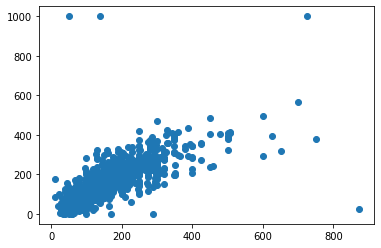

In [94]:
plt.figure()
plt.scatter(pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(y_test_preds))

<function matplotlib.pyplot.ylim(*args, **kwargs)>

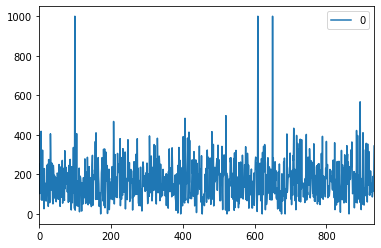

In [95]:
pd.DataFrame(y_test_preds).plot()
plt.ylim

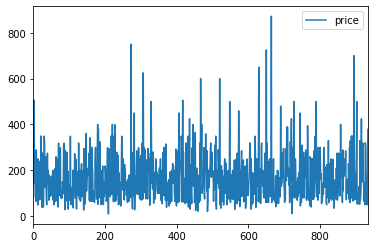

In [97]:
pd.DataFrame(y_test.reset_index(drop=True)).plot()

# Using summary to predict review_scores_value

In [41]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

# Keep NULL values, may not want to discard them
listings_df['summary'].fillna('NULL', inplace=True) 

listings_df['summary_tokens'] = listings_df['summary'].apply(tokenizer.tokenize)

In [42]:
summary_vocab = sorted(list(set(word for tokens in listings_df['summary_tokens'] for word in tokens)))

In [43]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Categorising Review of Value (with Logistic Regression)

## Using CountVectorizer

In [44]:
def count_vec(data): 
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    
    return emb, count_vectorizer

### Splitting into train and test

In [45]:
list_corpus = listings_df.dropna(subset=['review_scores_value'])['summary'].to_list()
list_values = listings_df.dropna(subset=['review_scores_value'])['review_scores_value'].to_list()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_values, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = count_vec(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Fit and Predict

In [46]:
clf = LogisticRegression(C=30, class_weight='balanced', solver='newton-cg', 
                              multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation

In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [48]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.383, precision = 0.416, recall = 0.383, f1 = 0.396


/home/tomc/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tomc/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/tomc/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tomc/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Inspection

In [51]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

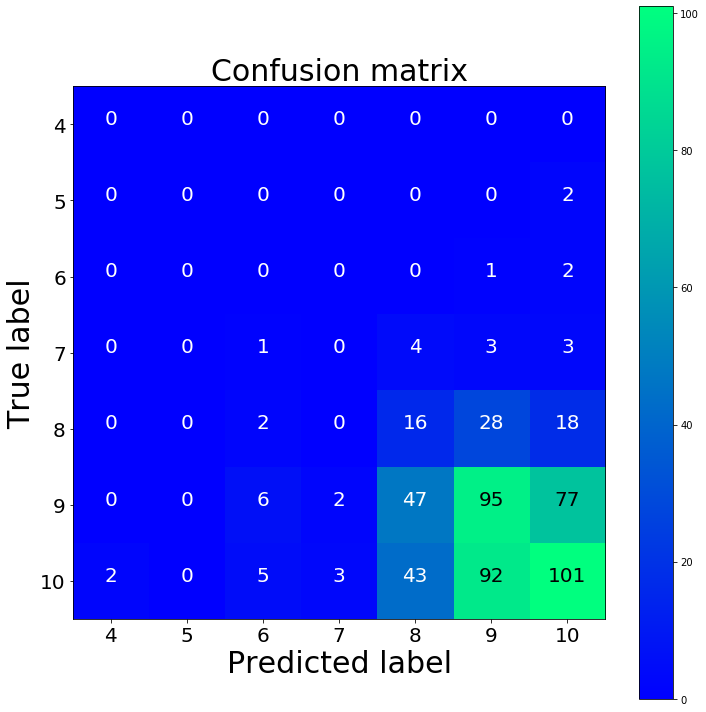

In [52]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10,10))
plot = plot_confusion_matrix(cm, classes=list(range(int(min(y_test)), int(max(y_test) + 1))), normalize=False)

## Using TFIDF to help deal with noise

In [53]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [54]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [55]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.407, precision = 0.427, recall = 0.407, f1 = 0.415


In [109]:
pd.DataFrame(y_test)[0].value_counts()

10.0    246
9.0     227
8.0      64
7.0      11
6.0       3
4.0       2
Name: 0, dtype: int64

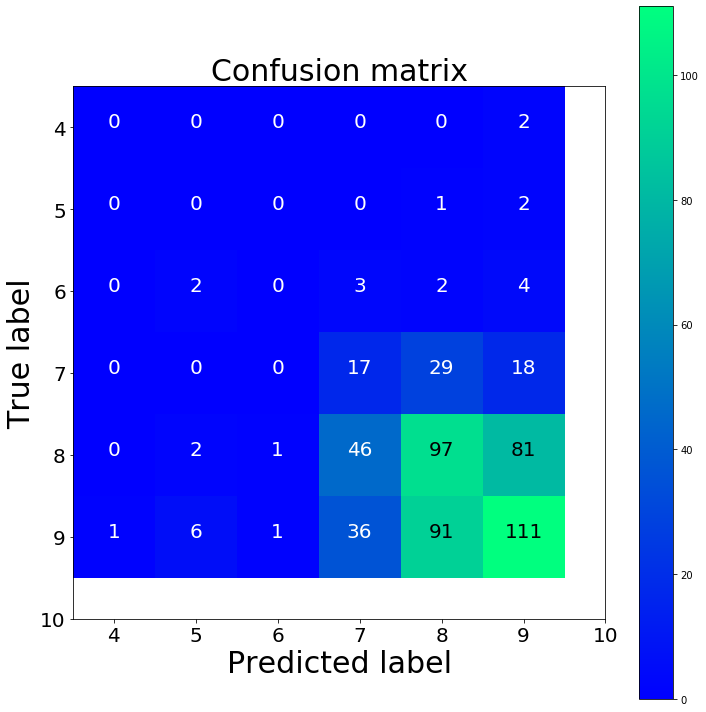

In [59]:
cm = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10,10))
plot = plot_confusion_matrix(cm, classes=list(range(int(min(y_test)), int(max(y_test) + 1))), normalize=False)